In [8]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

# 1. Загрузка датасета
df = pd.read_csv("protein_rightligand_interaction2.0.csv", index_col=0)

In [9]:
exclude_cols = {"Ligand", "Protein", "total_interactions"}
residue_cols = [col for col in df.columns if col not in exclude_cols]

# Функция для извлечения номера остатка 
def extract_resnr(col):
    match = re.search(r':(\d+)$', col)
    return int(match.group(1)) if match else 99999

In [10]:
sorted_residue_cols = sorted(residue_cols, key=extract_resnr)

all_types = {"hbond", "hydrophobic", "saltbridge", "waterbridge",
             "pistacking", "pication", "halogen", "metal"}

count_matrix = pd.DataFrame(0, index=sorted_residue_cols, columns=sorted(all_types))

In [11]:
for _, row in df.iterrows():
    for residue in sorted_residue_cols:
        cell = row[residue]
        if cell == 0 or pd.isna(cell):
            continue

        types = [t.strip() for t in str(cell).split(",") if t.strip() in all_types]
        for t in types:
            count_matrix.loc[residue, t] += 1

In [12]:
used_types = count_matrix.columns[count_matrix.sum() > 0]

color_map = {
    "hbond": "#1f77b4",          # синий
    "hydrophobic": "#ff7f0e",    # оранжевый
    "saltbridge": "#2ca02c",     # зелёный
    "waterbridge": "#d62728",    # красный
    "pistacking": "#9467bd",     # фиолетовый
    "pication": "#8c564b",       # коричневый
    "halogen": "#e377c2",        # розовый
    "metal": "#7f7f7f"           # серый
}
colors = [color_map[t] for t in used_types]

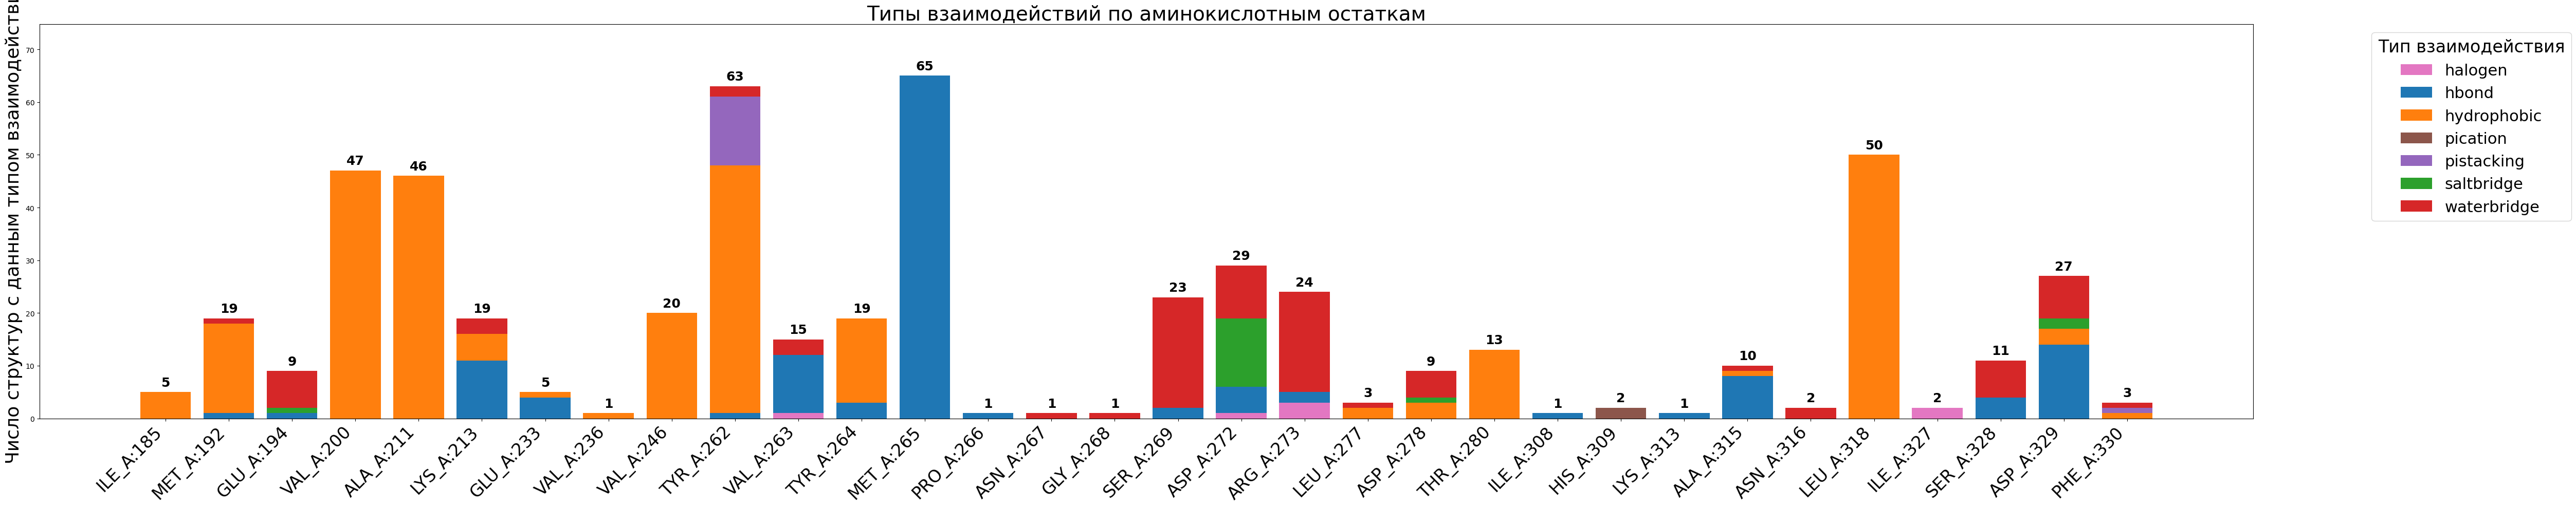

In [18]:
x_labels = count_matrix.index.tolist()
x_pos = np.arange(len(x_labels))
bottom = np.zeros(len(x_labels))

plt.figure(figsize=(50, 10))

total_heights = np.zeros(len(x_labels))

for interaction_type in used_types:
    values = count_matrix[interaction_type].values
    plt.bar(x_pos, values, bottom=bottom, color=color_map[interaction_type], label=interaction_type)
    bottom += values
    total_heights = bottom.copy()

ax = plt.gca()

y_max = total_heights.max()
if y_max > 0:
    plt.ylim(0, y_max * 1.15)
    
for i, height in enumerate(total_heights):
    if height > 0:
        ax.text(
            x_pos[i], height + max(total_heights) * 0.01, 
            str(int(height)),
            ha='center', va='bottom',
            fontsize=18, fontweight='bold'
        )

plt.xticks(x_pos, x_labels, rotation=45, ha='right', fontsize=24)
plt.ylabel("Число структур с данным типом взаимодействия", fontsize=26)
plt.title("Типы взаимодействий по аминокислотным остаткам", fontsize=28)
plt.legend(title="Тип взаимодействия", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=22, title_fontsize=24)
plt.tight_layout()
plt.savefig("barplot_AA.png", dpi=300, bbox_inches='tight')
plt.show()